# Projeto Final do Curso de Verão 2018

##### Aluna: Brenda Quesada Prallon

O projeto a seguir apreseta scripts de captura, armazenamento e vizualização da criptomoeda **polon**, em especial dos mercados **DASH/USDT** e **DASH/BTC**. 

Abaixo serão apresentados os códigos de captura e conexão com o banco de dados usando **sqlite**.

# Captura e banco de dados

In [1]:
import datetime 
import time
import numpy as np
import pandas as pd
import ccxt
import sqlite3

In [24]:
# Código de captura

# O código abaixo usou como base o seguinte exemplo:
# https://github.com/ccxt/ccxt/blob/master/examples/py/fetch-ohlcv-sequentially.py

def captura_poloniex(start, market):
    """Função que captura dados ohlcv, de 5 em 5 minutos de um dado mercado da corretora poloniex.
    Keyword arguments:
    start -- timestamp de início da captura
    market -- código do mercado para qual deve ser feita a captura
    Returns:
    um data frame com dados ohlcv do mercado"""
    # Instância da criptomoeda: poloniex
    exchange = ccxt.poloniex()
    data = [] # lista para capturar os dados
    now = exchange.milliseconds() # calcula data de agora
    while start + 30000 < now: # enquanto o timestamp de início + 5min for maior do que o timestamp de agora
        try:
            # printa de quando estão começando as candles
            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(start)) 
            # caputra as candles
            ohlcvs = exchange.fetch_ohlcv(market, '5m', start)
            # adiciona ao start o intervalo de tempo já capturado
            start += len(ohlcvs) * 300000
            # adiciona as candles na lista de dados
            data += ohlcvs
            # evita bloqueio por excesso de queries
            time.sleep (exchange.rateLimit / 1000)
        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:
            # se houver algum erro, printa o tipo de erro e espera 30 segundos para tentar de novo:
            print('Got an error', type(error).__name__, error.args, ', retrying in 30 seconds...')
            time.sleep(30)
    df_data = pd.DataFrame(data, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_data['market'] = market
    return(df_data)

In [25]:
# Fução que junta os dados de ambos os mercados em uma única lista de tuplas
def agregacao_mercados(from_timestamp):
    # captura os dados para o mercado DASH/BTC
    df_dash_btc = captura_poloniex(from_timestamp, "DASH/BTC")
    # captura os dados para o mercado DASH/USDT
    df_dash_usdt = captura_poloniex(from_timestamp, "DASH/USDT")
    # junta os dois mercados em um único dataframe
    df_data = df_dash_btc.append(df_dash_usdt, ignore_index = True)
    # Transforma em uma lista de tuplas, para inserção no banco de dados
    data = [tuple(x) for x in df_data.to_records(index=False)]
    return(data)

In [94]:
def atualiza_dados_sqlite():
    # Instância a poloniex para cálculo correto dos timestamps
    exchange = ccxt.poloniex()
    conn = sqlite3.connect('poloniex_data.db')
    sqlite3.register_adapter(np.int64, lambda val: int(val))
    c = conn.cursor()
    # Cria tabela
    c.execute('''CREATE TABLE IF NOT EXISTS poloniex_data
                 (timestamp integer, open real, high real, low real, close real, volume real, market text)''')
    # Busca timestamp mais recente
    timestamp_max = pd.read_sql_query('SELECT MAX(timestamp) from poloniex_data', conn).iloc[0][0]
    # Se não há dados na tabela, calcula o timestamp da data de um ano para trás:
    if timestamp_max is None:
        # Calcula a data de um ano para trás:
        from_datetime = datetime.datetime.now() - datetime.timedelta(days=365)
        from_datetime = from_datetime.strftime('%Y-%m-%d %H:%M:%S')
        from_timestamp = exchange.parse8601(from_datetime)
    # Se há dados na tabela, calcula o timestamp de 5 minutos após o último timestamp
    else:
        from_timestamp = timestamp_max + 30000
    if from_timestamp < exchange.milliseconds():
        # Busca os dados:
        data = agregacao_mercados(from_timestamp)
        # Insere os novos dados na tabela
        c.executemany('INSERT INTO poloniex_data VALUES (?,?,?,?,?,?,?)', data)
        # salva as mudanças 
        conn.commit()
    else:
        print("Os dados já estão atualizados!")
    # Fecha a conexão 
    conn.close()

In [98]:
# Executa a função:
atualiza_dados_sqlite()

1516891345424 Fetching candles starting from 2017-01-25T12:42:25.000Z
1516891352097 Fetching candles starting from 2017-01-25T12:42:25.000Z


In [99]:
# Leitura dos dados como data frame:
conn = sqlite3.connect('poloniex_data.db')
dados = pd.read_sql_query('SELECT * from poloniex_data', conn)
dados.head()

timestamp      open      high       low     close    volume    market
0  1485348300000  0.015546  0.015546  0.015530  0.015546  0.003500  DASH/BTC
1  1485348600000  0.015546  0.015563  0.015546  0.015563  0.061967  DASH/BTC
2  1485348900000  0.015565  0.015565  0.015530  0.015565  0.000232  DASH/BTC
3  1485349200000  0.015565  0.015565  0.015530  0.015565  0.088433  DASH/BTC
4  1485349500000  0.015530  0.015576  0.015530  0.015576  0.059691  DASH/BTC

In [101]:
# checando se há dados para ambos os mercados
dados.market.value_counts()

DASH/BTC     105144
DASH/USDT    105144
Name: market, dtype: int64

In [102]:
# checando estatísticas dos dados
dados.describe()

timestamp           open           high            low  \
count  2.102880e+05  210288.000000  210288.000000  210288.000000   
mean   1.501120e+12     153.219202     153.650478     152.748299   
std    9.105759e+09     267.896153     268.771552     266.919286   
min    1.485348e+12       0.015487       0.015513       0.015391   
25%    1.493234e+12       0.063049       0.063270       0.062821   
50%    1.501120e+12       6.866695       6.867078       6.860600   
75%    1.509005e+12     192.700000     193.000000     192.200000   
max    1.516891e+12    1547.017600    1575.000000    1533.050328   

               close         volume  
count  210288.000000  210288.000000  
mean      153.209775    2956.327882  
std       267.864818   13514.612737  
min         0.015486       0.000000  
25%         0.063063       1.408040  
50%         6.866695      11.021060  
75%       192.700000     796.253901  
max      1548.520200  901377.148533

In [105]:
# checando se não há duplicatas:
dados[dados.duplicated()]

Empty DataFrame
Columns: [timestamp, open, high, low, close, volume, market]
Index: []

In [113]:
# checando a data máxima e mínnima dos dados (pode haver uma pequena diferença entre a hora de início de 2017 e a hora final de 2018)
print(datetime.datetime.fromtimestamp(max(dados.timestamp)/1000).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.datetime.fromtimestamp(min(dados.timestamp)/1000).strftime('%Y-%m-%d %H:%M:%S'))

2018-01-25 12:40:00
2017-01-25 10:45:00


Como tudo parece estar certo, a próxima parte será dedicada a formar visualizações desses dados:

# Visualizações


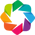

In [115]:
import holoviews as hv
hv.notebook_extension('bokeh')

In [148]:
dados['date'] = pd.to_datetime(dados.timestamp, unit = 'ms')

timestamp        open        high         low       close  \
0       1485348300000    0.015546    0.015546    0.015530    0.015546   
1       1485348600000    0.015546    0.015563    0.015546    0.015563   
2       1485348900000    0.015565    0.015565    0.015530    0.015565   
3       1485349200000    0.015565    0.015565    0.015530    0.015565   
4       1485349500000    0.015530    0.015576    0.015530    0.015576   
5       1485349800000    0.015565    0.015585    0.015515    0.015515   
6       1485350100000    0.015552    0.015603    0.015487    0.015490   
7       1485350400000    0.015491    0.015589    0.015491    0.015513   
8       1485350700000    0.015504    0.015513    0.015504    0.015504   
9       1485351000000    0.015513    0.015513    0.015504    0.015513   
10      1485351300000    0.015513    0.015554    0.015513    0.015513   
11      1485351600000    0.015513    0.015513    0.015486    0.015486   
12      1485351900000    0.015487    0.015550    0.015487    0.015487   
13      1485352200000    0.015550    0.015550    0.015487    0.015487   
14      1485352500000    0.015522    0.015549    0.015391    0.015533   
15      1485352800000    0.015533    0.015533    0.015530    0.015530   
16      1485353100000    0.015533    0.015577    0.015533    0.015577   
17      1485353400000    0.015533    0.015580    0.015533    0.015580   
18      1485353700000    0.015533    0.015580    0.015515    0.015579   
19      1485354000000    0.015579    0.015580    0.015579    0.015580   
20      1485354300000    0.015579    0.015602    0.015579    0.015600   
21      1485354600000    0.015579    0.015579    0.015579    0.015579   
22      1485354900000    0.015600    0.015600    0.015488    0.015488   
23      1485355200000    0.015488    0.015558    0.015488    0.015491   
24      1485355500000    0.015553    0.015559    0.015553    0.015558   
25      1485355800000    0.015558    0.015589    0.015558    0.015589   
26      1485356100000    0.015558    0.015589    0.015558    0.015566   
27      1485356400000    0.015589    0.015589    0.015558    0.015558   
28      1485356700000    0.015558    0.015558    0.015558    0.015558   
29      1485357000000    0.015558    0.015558    0.015491    0.015491   
...               ...         ...         ...         ...         ...   
210258  1516882500000  785.000000  785.000000  785.000000  785.000000   
210259  1516882800000  784.500000  785.000000  783.500002  785.000000   
210260  1516883100000  783.500002  783.500003  783.500002  783.500003   
210261  1516883400000  786.394059  786.394059  786.394059  786.394059   
210262  1516883700000  786.394059  786.394059  783.500003  783.500003   
210263  1516884000000  785.120697  785.120697  783.500003  783.500003   
210264  1516884300000  783.500003  783.500003  783.500003  783.500003   
210265  1516884600000  783.500003  783.500003  783.500003  783.500003   
210266  1516884900000  783.500003  783.500003  778.442239  782.000000   
210267  1516885200000  782.000000  782.000000  782.000000  782.000000   
210268  1516885500000  783.500003  783.500003  783.500003  783.500003   
210269  1516885800000  783.400000  783.400000  783.400000  783.400000   
210270  1516886100000  783.400000  783.400000  783.400000  783.400000   
210271  1516886400000  783.564000  783.564000  783.564000  783.564000   
210272  1516886700000  784.000000  784.947031  784.000000  784.947031   
210273  1516887000000  784.947031  784.947031  784.947031  784.947031   
210274  1516887300000  784.100000  784.100000  784.100000  784.100000   
210275  1516887600000  784.947031  785.292239  784.947031  785.292239   
210276  1516887900000  786.394059  789.364261  786.394059  789.364261   
210277  1516888200000  789.394059  794.244875  789.394059  790.451662   
210278  1516888500000  790.451662  794.685401  790.451662  792.685401   
210279  1516888800000  794.685401  794.685401  791.000000  791.000000   
210280  1516889100000  791.010000  791.010000  791.000000  791.000000 

In [245]:
teste_1 = dados.loc[dados['market'] == 'DASH/USDT', :]
teste_2 = dados.loc[dados['market'] == 'DASH/BTC', :]

In [158]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    #df.reset_index(level=0, inplace=True)
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['DASH/USDT', 'DASH/BTC',]
data = {"DASH/USDT": teste_1, 'DASH/BTC':teste_2}
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [159]:
%%opts Curve [width=700] {+framewise}
dmap

:DynamicMap   [Symbol]

In [192]:
%%opts Scatter [width=700] (color='black')
smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
smoothed

:DynamicMap   [Symbol]

In [246]:
teste_1 = teste_1.copy()
teste_2 = teste_2.copy()

In [248]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_vol(w, symbol):
    dt = data[symbol]
    S = dt['close'].rolling(w).std()
    dt['Volatility'] = S
    dt['date'] = teste_1.date

    return hv.Curve(dt.iloc[-2000:], ('date', 'Date'), ('Volatility','Rolling volatility'))

stock_symbols = ['DASH/USDT', 'DASH/BTC',]
data = {"DASH/USDT": teste_1, 'DASH/BTC':teste_2}   
winsize = range(10,60,2)
rvol = hv.DynamicMap(rolling_vol, kdims=['Wsize', 'Symbol']).redim.values(Symbol=stock_symbols).redim.range(Wsize=(10,60))
rvol

:DynamicMap   [Wsize,Symbol]

In [319]:
from math import pi
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
output_notebook()
df = teste_2.copy()
df['day'] = df.date.dt.date
df = df[['day', 'open', 'high', 'low', 'close', 'volume']]
df = df.groupby('day', as_index = False).mean()
inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "teste")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df.day, df.high, df.day, df.low, color="black")
p.vbar(df.day[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.day[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

show(p)  

Loading BokehJS ...

In [359]:
df = teste_2.copy()
df['day'] = df.date.dt.date
df = df[['day', 'open', 'high', 'low', 'close', 'volume']]
f = {'open': ['first'], 'high': ['max'], 'low': ['min'], 'close': ['last'], 'volume' : ['sum']}
df = df.groupby('day', as_index = False).agg(f)
df.columns = df.columns.droplevel(1)
inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "teste")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df.day, df.high, df.day, df.low, color="black")
p.vbar(df.day[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.day[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

show(p)  

In [358]:
df = teste_2.copy()
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['date'] = df.date.dt.date
df = df[['date','year', 'month', 'open', 'high', 'low', 'close', 'volume']]
f = {'date': ['first'], 'open': ['first'], 'high': ['max'], 'low': ['min'], 'close': ['last'], 'volume' : ['sum']}
df = df.groupby(['year','month'], as_index = False).agg(f)
df.columns = df.columns.droplevel(1)
inc = df.close > df.open
dec = df.open > df.close
w = 24*60*60*1000*15 # half month in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "teste")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df.date, df.high, df.date, df.low, color="black")
p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

show(p)  